# Apresentação e Objetivo do Projeto
Data Science Academy

Big Data Real-Time Analytics com Python e Spark

Miniprojeto 4: Prever rotatividade em empresa de Telecom

Autor: José Ângelo de Assis Júnior

# FASE 1: Importação das Bibliotecas

In [0]:
# imports necessários:
# obrigatorios
import pandas  as pd
import numpy   as np
# visualizacao
import matplotlib.pyplot as plt
import seaborn as sns
# pre-processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# modelos
from sklearn.model_selection  import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
from sklearn.linear_model     import LogisticRegression
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.tree             import DecisionTreeClassifier
from sklearn.ensemble         import RandomForestClassifier
from xgboost                  import XGBClassifier
from sklearn.ensemble         import GradientBoostingClassifier
# avaliação dos modelos
from sklearn.metrics          import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics          import roc_curve
from sklearn.metrics          import roc_auc_score

In [0]:
# importar arquivos csv para dataframe pandas
df_treino = pd.read_csv('projeto4_telecom_treino.csv')
df_teste  = pd.read_csv('projeto4_telecom_teste.csv')

In [3]:
df_treino.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [4]:
df_teste.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,HI,101,area_code_510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,2,MT,137,area_code_510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,3,OH,103,area_code_408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,4,NM,99,area_code_415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,5,SC,108,area_code_415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


In [5]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Unnamed: 0                       3333 non-null int64
state                            3333 non-null object
account_length                   3333 non-null int64
area_code                        3333 non-null object
international_plan               3333 non-null object
voice_mail_plan                  3333 non-null object
number_vmail_messages            3333 non-null int64
total_day_minutes                3333 non-null float64
total_day_calls                  3333 non-null int64
total_day_charge                 3333 non-null float64
total_eve_minutes                3333 non-null float64
total_eve_calls                  3333 non-null int64
total_eve_charge                 3333 non-null float64
total_night_minutes              3333 non-null float64
total_night_calls                3333 non-null int64
total_night_charge               3333 non-null float64
total_intl_minutes           

In [6]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 21 columns):
Unnamed: 0                       1667 non-null int64
state                            1667 non-null object
account_length                   1667 non-null int64
area_code                        1667 non-null object
international_plan               1667 non-null object
voice_mail_plan                  1667 non-null object
number_vmail_messages            1667 non-null int64
total_day_minutes                1667 non-null float64
total_day_calls                  1667 non-null int64
total_day_charge                 1667 non-null float64
total_eve_minutes                1667 non-null float64
total_eve_calls                  1667 non-null int64
total_eve_charge                 1667 non-null float64
total_night_minutes              1667 non-null float64
total_night_calls                1667 non-null int64
total_night_charge               1667 non-null float64
total_intl_minutes           

In [7]:
df_treino.shape

(3333, 21)

In [8]:
df_teste.shape

(1667, 21)

# FASE 2: Primeiro Processo de ETL

In [9]:
# checar valores missing em treino
missing_val_count_by_column_treino = (df_treino.isnull().sum())
print(missing_val_count_by_column_treino[missing_val_count_by_column_treino > 0])
# checar valores missing em teste
missing_val_count_by_column_teste = (df_teste.isnull().sum())
print(missing_val_count_by_column_teste[missing_val_count_by_column_teste > 0])

Series([], dtype: int64)
Series([], dtype: int64)


In [10]:
# valores NaN treino
nan_val_count_by_column_treino = (df_treino.isna().sum())
print(nan_val_count_by_column_treino[nan_val_count_by_column_treino > 0])
# valores NaN teste
nan_val_count_by_column_teste = (df_teste.isna().sum())
print(nan_val_count_by_column_teste[nan_val_count_by_column_teste > 0])

Series([], dtype: int64)
Series([], dtype: int64)


In [0]:
# O campo Unnamed: 0 é um contador de linhas, removê-lo
df_treino.drop('Unnamed: 0', axis = 1, inplace = True)
df_teste.drop('Unnamed: 0',  axis = 1, inplace = True)

# FASE 3: Segundo Processo de ETL e Análise dos Dados

In [12]:
# visualizar estatísticas das observações
df_treino.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


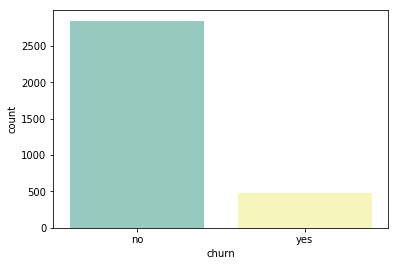

In [13]:
# visualizar a contagem do campo TARGET em treino
ax = sns.countplot(x = 'churn', data = df_treino, palette = 'Set3')

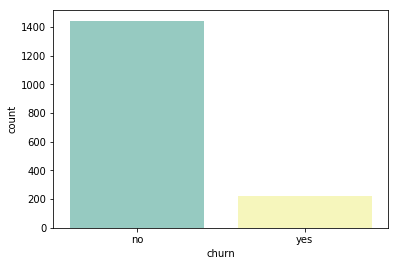

In [14]:
# visualizar a contagem do campo TARGET em teste
ax = sns.countplot(x = 'churn', data = df_teste, palette = 'Set3')

In [0]:
# substituir 'no' por 1 e 'yes' por zero
df_treino['churn'] = df_treino['churn'].map({'no': 1, 'yes': 0})
df_teste['churn']  = df_teste['churn'].map({'no': 1, 'yes': 0})

In [0]:
# lista de colunas categóricas
lista_cat_cols = [col for col in df_treino.columns if df_treino[col].dtype == 'object']

In [17]:
# Colunas categóricas presentes em ambos dataframes - 'good-cols'
good_label_cols = [col for col in lista_cat_cols if set(df_treino[col]) == set(df_teste[col])]
        
# Colunas categóricas presente em um datagrame devem ser removidas - 'bad-cols'
bad_label_cols = list(set(lista_cat_cols) - set(good_label_cols))
        
print('Colunas categóricas para label encoded:', good_label_cols)
print('\nColunas categóricas que devem ser removidas do dataset:', bad_label_cols)

Colunas categóricas para label encoded: ['state', 'area_code', 'international_plan', 'voice_mail_plan']

Colunas categóricas que devem ser removidas do dataset: []


In [18]:
good_label_cols

['state', 'area_code', 'international_plan', 'voice_mail_plan']

In [19]:
# cardinalidade - número de valores únicos em cada coluna categórica
ls_vlrs_unicos = list(map(lambda col: df_treino[col].nunique(), lista_cat_cols))
d = dict(zip(lista_cat_cols, ls_vlrs_unicos))

# valores únicos por coluna em ordem ascendente
sorted(d.items(), key=lambda x: x[1])

[('international_plan', 2),
 ('voice_mail_plan', 2),
 ('area_code', 3),
 ('state', 51)]

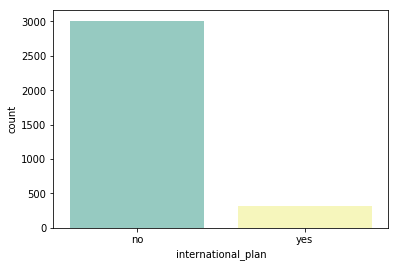

In [20]:
# visualizar as colunas categóricos com até 3 valores distintos
# dataset de treino:
ax = sns.countplot(x = 'international_plan', data = df_treino, palette = 'Set3')

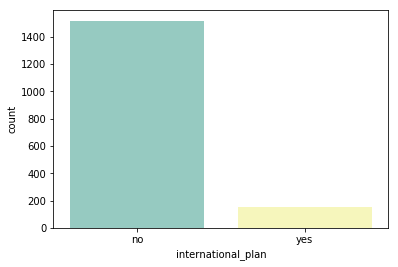

In [21]:
# dataset de teste:
ax = sns.countplot(x = 'international_plan', data = df_teste, palette = 'Set3')

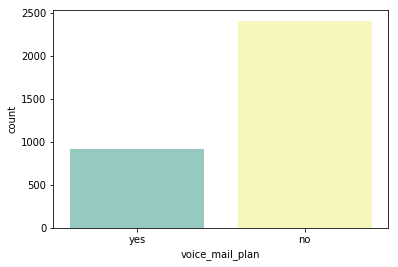

In [22]:
# dataset de treino:
ax = sns.countplot(x = 'voice_mail_plan', data = df_treino, palette = 'Set3')

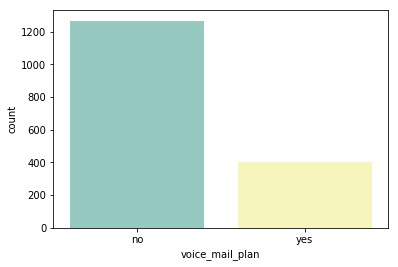

In [23]:
# dataset de teste:
ax = sns.countplot(x = 'voice_mail_plan', data = df_teste, palette = 'Set3')

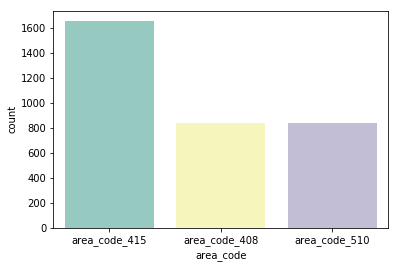

In [24]:
# dataset de treino
ax = sns.countplot(x = 'area_code', data = df_treino, palette = 'Set3')

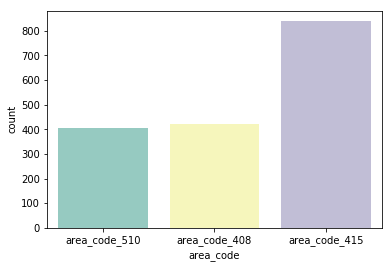

In [25]:
# dataset de teste
ax = sns.countplot(x = 'area_code', data = df_teste, palette = 'Set3')

In [26]:
# Colunas que vão passar pelo processo de one-hot-encoded:
ls_baixa_cardinalidade = [col for col in lista_cat_cols if df_treino[col].nunique() < 10]

# colunas que serão removidas por terem alta cardinalidade (não contribuem com predição)
ls_alta_cardinalidade  = list(set(lista_cat_cols) - set(ls_baixa_cardinalidade))

print('Colunas categóricas que passaram por one-hot encoded:', ls_baixa_cardinalidade)
print('\nColunas categóricas que serão excluídas dos datasets:', ls_alta_cardinalidade)

Colunas categóricas que passaram por one-hot encoded: ['area_code', 'international_plan', 'voice_mail_plan']

Colunas categóricas que serão excluídas dos datasets: ['state']


In [0]:
# remover colunas com alta cardinalidade (não contribuem com predição)
df_treino.drop(ls_alta_cardinalidade, axis = 1, inplace = True)
df_teste.drop(ls_alta_cardinalidade,  axis = 1, inplace = True)

In [0]:
# aplicar o one-hot encoding sobre cada coluna categórica restante
# instanciar o one-hot-enconder com:
#    handle_unknown = 'ignore': para evitar quando as classes de treino e teste forem diferentes
#    sparse = False: para que seja retornado Numpy array e não matriz esparsa
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# aplicar nos datasets
OH_cols_treino = pd.DataFrame(OH_encoder.fit_transform(df_treino[ls_baixa_cardinalidade]))
OH_cols_teste  = pd.DataFrame(OH_encoder.transform(df_teste[ls_baixa_cardinalidade]))

In [0]:
# o processo de one-hot encoding remove os índices, reinseri-los
OH_cols_treino.index = df_treino.index
OH_cols_teste.index  = df_teste.index

In [0]:
# remover os dados categóricos dos dataframes, para serem substituídos pelos acima
df_treino.drop(ls_baixa_cardinalidade, axis = 1, inplace = True)
df_teste.drop(ls_baixa_cardinalidade,  axis = 1, inplace = True)

In [0]:
# concatenar os datasets com os hot-encoded
df_treino = pd.concat([df_treino, OH_cols_treino], axis = 1)
df_teste  = pd.concat([df_teste,  OH_cols_teste],  axis = 1)

In [32]:
# ver resultado:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
account_length                   3333 non-null int64
number_vmail_messages            3333 non-null int64
total_day_minutes                3333 non-null float64
total_day_calls                  3333 non-null int64
total_day_charge                 3333 non-null float64
total_eve_minutes                3333 non-null float64
total_eve_calls                  3333 non-null int64
total_eve_charge                 3333 non-null float64
total_night_minutes              3333 non-null float64
total_night_calls                3333 non-null int64
total_night_charge               3333 non-null float64
total_intl_minutes               3333 non-null float64
total_intl_calls                 3333 non-null int64
total_intl_charge                3333 non-null float64
number_customer_service_calls    3333 non-null int64
churn                            3333 non-null int64
0                            

In [33]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 23 columns):
account_length                   1667 non-null int64
number_vmail_messages            1667 non-null int64
total_day_minutes                1667 non-null float64
total_day_calls                  1667 non-null int64
total_day_charge                 1667 non-null float64
total_eve_minutes                1667 non-null float64
total_eve_calls                  1667 non-null int64
total_eve_charge                 1667 non-null float64
total_night_minutes              1667 non-null float64
total_night_calls                1667 non-null int64
total_night_charge               1667 non-null float64
total_intl_minutes               1667 non-null float64
total_intl_calls                 1667 non-null int64
total_intl_charge                1667 non-null float64
number_customer_service_calls    1667 non-null int64
churn                            1667 non-null int64
0                            

In [34]:
# calcular a correlação:
df_treino[df_treino.columns[0:]].corr()['churn'][:]

account_length                  -0.016541
number_vmail_messages            0.089728
total_day_minutes               -0.205151
total_day_calls                 -0.018459
total_day_charge                -0.205151
total_eve_minutes               -0.092796
total_eve_calls                 -0.009233
total_eve_charge                -0.092786
total_night_minutes             -0.035493
total_night_calls               -0.006141
total_night_charge              -0.035496
total_intl_minutes              -0.068239
total_intl_calls                 0.052844
total_intl_charge               -0.068259
number_customer_service_calls   -0.208750
churn                            1.000000
0                               -0.001103
1                                0.006535
2                               -0.006423
3                                0.259852
4                               -0.259852
5                               -0.102148
6                                0.102148
Name: churn, dtype: float64

# FASE 4: ML parte 1 - Treinar Diversos Modelos e Detectar os Melhores

In [0]:
# cross-validation
num_folds = 8
seed      = 7

# definir os dados
X = df_treino.drop('churn', axis = 1) # preditores
Y = df_treino['churn'] # classe

# Separar os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Definir o número de árvores
num_trees    = 500
max_features = 3

# instanciar os modelos
model_1 = LogisticRegression()
model_2 = LinearDiscriminantAnalysis()
model_3 = KNeighborsClassifier()
model_4 = DecisionTreeClassifier()
model_5 = RandomForestClassifier(n_estimators=num_trees, max_depth=2, max_features = max_features, random_state=seed)
model_6 = XGBClassifier()
model_7 = GradientBoostingClassifier(n_estimators = num_trees, random_state = seed)

# criar dicionário de modelos:
dict_models = {'Regr_log': model_1, 'LDA': model_2, 'KNN': model_3, 'Dec_Tree': model_4,
               'RandForest': model_5, 'XGB': model_6, 'GradBoos': model_7}

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

modelo:  Regr_log
resultado:  0.8583777209002029
modelo:  LDA
resultado:  0.8520719482106622


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn

modelo:  KNN
resultado:  0.8784760653016048
modelo:  Dec_Tree
resultado:  0.9159914856576278
modelo:  RandForest
resultado:  0.8550717118612802
modelo:  XGB
resultado:  0.9513891290813503
modelo:  GradBoos
resultado:  0.9543888927319684


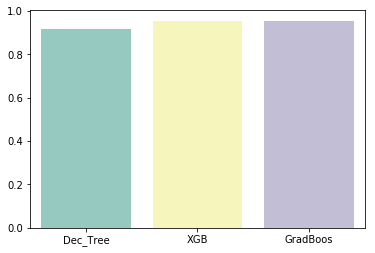

In [36]:
# treinar os modelos e selecionar os melhores
dict_acuracia_modelos = {}

for k, v in dict_models.items():
    resultado = cross_val_score(v, X, Y, cv = kfold)
    acuracia  = resultado.mean()
    print('modelo: ', k)
    print('resultado: ', acuracia)
    if (acuracia > 0.9):
        dict_acuracia_modelos[k] = acuracia
        
# Melhores resultados:
ax = sns.barplot(x = list(dict_acuracia_modelos.keys()),
                 y = list(dict_acuracia_modelos.values()),
                 hue_order = list(dict_acuracia_modelos.keys()),
                 palette = 'Set3')

# FASE 4: ML parte 2 - Tunning Parâmetros para Melhores Modelos

In [37]:
# Melhores modelos: Decision Tree, XGB e Gradent Boosting
# Fazer tunning dos melhores modelos para aplicar validação

# Definindo os valores para tunning
XGB_parm = {'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]}

Dec_Tree = dict(min_samples_split = list(range(2, 50)))

GB_Class = {'learning_rate': [0.1, 0.2, 0.5],
            'max_depth': [10, 20, 50],
            'max_features': [0.5, 0.8, 1.0],
            'max_leaf_nodes': [10, 50, 100],
            'min_impurity_decrease': [0, 0.1, 0.2],
            'min_samples_leaf': [5, 10, 20],
            'min_samples_split': [5, 10, 20],
            'n_estimators': [10, 50, 100]}
    
# instanciar os modelos
modelo_XGB_parm = XGBClassifier()
modelo_Dec_Tree = DecisionTreeClassifier()
modelo_GB_Class = GradientBoostingClassifier()

# Criar o grid XGB
grid_XGB = GridSearchCV(n_jobs = -1, estimator = modelo_XGB_parm, param_grid = XGB_parm)
grid_XGB.fit(X, Y)
# Print dos resultados
print("Acurácia XGB: %.3f" % (grid_XGB.best_score_ * 100))
print("Melhores Parâmetros XGB:\n", grid_XGB.best_estimator_)

# Criar o grid Decision Tree
grid_Dec_Tree = GridSearchCV(n_jobs = -1, estimator = modelo_Dec_Tree, param_grid = Dec_Tree)
grid_Dec_Tree.fit(X, Y)
# Print dos resultados
print("Acurácia Dec_Tree: %.3f" % (grid_Dec_Tree.best_score_ * 100))
print("Melhores Parâmetros Dec_Tree:\n", grid_Dec_Tree.best_estimator_)

# Criar o grid Gradient Boosting
grid_GB_Class = GridSearchCV(n_jobs = -1, estimator = modelo_GB_Class, param_grid = GB_Class)
grid_GB_Class.fit(X, Y)
# Print dos resultados
print("Acurácia GB_Class: %.3f" % (grid_GB_Class.best_score_ * 100))
print("Melhores Parâmetros GB_Class:\n", grid_GB_Class.best_estimator_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Acurácia XGB: 95.920
Melhores Parâmetros XGB:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Acurácia Dec_Tree: 92.199
Melhores Parâmetros Dec_Tree:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Acurácia GB_Class: 95.890
Melhores Parâmetros GB_Class:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=50,
                           max_features=0.5, max_leaf_nodes=50,
                           min_impurity_decrease=0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


# FASE FINAL: Avaliação dos Melhores Modelos

In [0]:
# função para criar a matriz de confusão
# fonte: documentação do sklearn

def plot_confusion_matrix(y_true,
                          y_pred, 
                          classes,
                          nome_modelo,
                          normalize = False,
                          title     = None,
                          cmap      = plt.cm.OrRd):

    title = 'Matriz de Confusão ' + nome_modelo

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax = ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Categoria real',
           xlabel='Categoria predita')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision = 2)

In [0]:
# função para calcular e plotar AUC
# fonte: https://machinelearningmastery.com
def plot_auc(x_validacao, y_validacao, modelo_ml):
  # predizer probabilidades
  probs = modelo_ml.predict_proba(x_validacao)
  # manter somente as saídas positivas das probabilidades
  probs = probs[:, 1]
  # calcular AUC
  auc = roc_auc_score(y_validacao, probs)
  print('AUC: %.3f' % auc)
  # calculate roc curve
  fpr, tpr, thresholds = roc_curve(y_validacao, probs)
  # imprimir linha divisora (no skill)
  plt.plot([0, 1], [0, 1], linestyle='--')
  # plotar AUC para o modelo
  plt.plot(fpr, tpr, marker = '.')
  # exibir o plot
  plt.show()

In [0]:
# avaliar o resultado usando matriz de confusão e a área sob a curva em cada modelo:
# divisão dos dados de validação:
df_validacao = df_teste.drop('churn', axis = 1)
df_vl_target = df_teste['churn']

# rótulos da classe que se quer prever:
nm_clss_alvo = [0, 1]

In [0]:
# fazer as predições sobre o dataset de teste, com os valores apurados de hiperparâmetro nos melhores modelos:
y_pred_grid_GB_Class = grid_GB_Class.predict(df_validacao)
y_pred_grid_XGB      = grid_XGB.predict(df_validacao)
y_pred_grid_Dec_Tree = grid_Dec_Tree.predict(df_validacao)

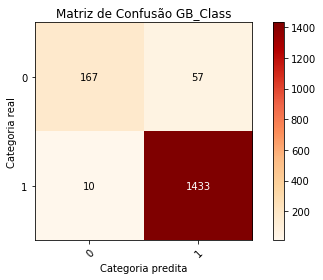

In [46]:
# Matriz de confusão para Gradient Boosting
plot_confusion_matrix(df_vl_target,
                      y_pred_grid_GB_Class,
                      nm_clss_alvo,
                      nome_modelo = 'GB_Class')

plt.show()

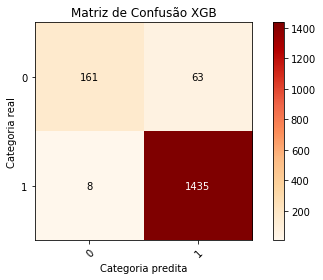

In [47]:
# Matriz de confusão para Classificador XGB
plot_confusion_matrix(df_vl_target,
                      y_pred_grid_XGB,
                      nm_clss_alvo,
                      nome_modelo = 'XGB')

plt.show()

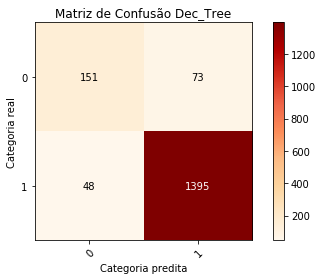

In [49]:
# Matriz de confusão para Árvores de Decisão
plot_confusion_matrix(df_vl_target,
                      y_pred_grid_Dec_Tree,
                      nm_clss_alvo,
                      nome_modelo = 'Dec_Tree')

plt.show()

AUC: 0.924


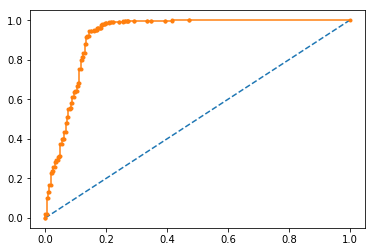

In [57]:
plot_auc(df_validacao, df_vl_target, grid_GB_Class)

AUC: 0.931


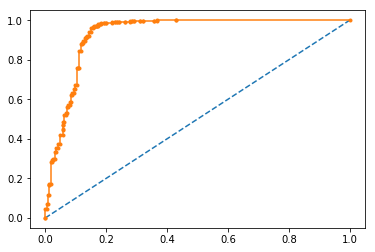

In [58]:
plot_auc(df_validacao, df_vl_target, grid_XGB)

AUC: 0.882


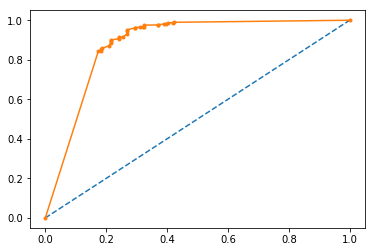

In [59]:
plot_auc(df_validacao, df_vl_target, grid_Dec_Tree)

Para estes conjuntos de dados, foi verificado que os modelos que retornam os melhores resultados de predição são **XGB** e o **Gradient Boosting**. O XGB foi levemente superior na avaliação sob a ótica da Área Sob a Curva, já o Gradiente Boosting apresentou menor quantidade de erros (4 apenas) na matriz de confusão. Esta avaliação levou em consideração duas medidas: a matriz de confusão é a área sob a curva.